In [10]:
# -----------------------------
# Cell 1 — Setup & reproducibility
# -----------------------------
# Install helper libraries quietly:
# - tabula-py: used to extract tables from PDF survey files
# - torchinfo: prints a readable summary of PyTorch models
!pip install -q tabula-py
!pip install -q torchinfo

# --- Standard Python utilities ---
# os: file paths and existence checks
# random: Python-level randomness
# datetime: used later for time-aware heuristics
import os
import random
from datetime import datetime

# --- Data handling and plotting ---
# numpy / pandas: numerical arrays and tabular data
# matplotlib: plotting training loss and evaluation curves
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- PyTorch (neural network framework) ---
# torch: core tensor library
# nn / functional: neural network layers and activations
# optim: optimizers (Adam)
# DataLoader: minibatch iteration
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# --- Scikit-learn (preprocessing helpers) ---
# train_test_split: reproducible data splits
# SimpleImputer: fill missing values
# OrdinalEncoder / StandardScaler: encode categories and scale numerics
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# --- Utility ---
# torchinfo.summary prints a clean layer-by-layer model summary
from torchinfo import summary

# --- Google Colab helpers ---
# drive: access files in Google Drive
# tabula: extract tables from PDFs
# shutil: copy files between locations
from google.colab import drive
import tabula
import shutil

# --- Device and reproducibility settings ---
# Use GPU if available; otherwise fall back to CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 42

# Set all relevant random seeds so experiments are repeatable
def set_seed(seed_value=RANDOM_SEED):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        # Force deterministic behavior for CuDNN where possible
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"[info] Global seed set to {seed_value}; device = {DEVICE}")

set_seed()


[info] Global seed set to 42; device = cpu


In [11]:
# -----------------------------
# Cell 2 — PDF extraction, cleaning, and feature construction
# -----------------------------
# Toggle whether to re-extract data from the PDF or reuse an existing CSV
USE_PDF_EXTRACTION = True

# Location of the survey PDF in Google Drive
PDF_PATH = "/content/drive/MyDrive/Thesis/Capstone Survey(Responses).pdf"

# Name of the cleaned CSV file produced by this step
CSV_PATH = "survey_responses_cleaned_for_feature_engineering.csv"

# Fixed input size expected by the autoencoder
INPUT_DIM = 8

# Mount Google Drive so the notebook can access the PDF
drive.mount('/content/drive')

# --- Extract tables from the PDF if enabled ---
if USE_PDF_EXTRACTION:
    if not os.path.exists(PDF_PATH):
        raise FileNotFoundError(f"PDF not found at: {PDF_PATH}")

    print("[info] Extracting tables from PDF:", PDF_PATH)

    # Read all tables from all pages of the PDF
    dfs = tabula.read_pdf(PDF_PATH, pages="all", multiple_tables=True, lattice=True)
    print(f"[info] Tables extracted: {len(dfs)}")

    # Combine all extracted tables into a single DataFrame
    df = pd.concat(dfs, ignore_index=True)

    # Clean column headers (remove line breaks and extra whitespace)
    df.columns = [str(c).replace("\r", " ").strip() for c in df.columns]

    # Identify columns that contain timestamps, consent text, or names
    remove_substrings = [
        "timestamp",
        "do you agree to paricipate",
        "provide your name"
    ]

    cols_to_drop = [col for col in df.columns if any(sub in col.lower() for sub in remove_substrings)]
    print("[info] Dropping columns:", cols_to_drop)

    # Drop non-feature and privacy-related columns
    df_clean = df.drop(columns=cols_to_drop, errors="ignore")

    # Save cleaned data locally and copy it back to Drive
    df_clean.to_csv(CSV_PATH, index=False)
    dest_dir = "/content/drive/MyDrive/Thesis"
    os.makedirs(dest_dir, exist_ok=True)
    shutil.copy(CSV_PATH, os.path.join(dest_dir, CSV_PATH))

    print(f"[info] Cleaned CSV saved as {CSV_PATH} and copied to Drive/{dest_dir}")
else:
    print("[info] Skipping PDF extraction; using existing CSV.")

# --- Load cleaned CSV ---
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found at {CSV_PATH}")

df = pd.read_csv(CSV_PATH)
print("[info] Loaded CSV:", CSV_PATH, "shape:", df.shape)
# -----------------------------
# Feature engineering
# -----------------------------
# Select the first INPUT_DIM columns as the autoencoder features
chosen_features = list(df.columns[:INPUT_DIM])
print("[info] Using features:", chosen_features)

# Split selected features into numeric vs categorical
numeric_cols = [c for c in chosen_features if pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in chosen_features if c not in numeric_cols]

X_parts = []

# --- Numeric preprocessing ---
if numeric_cols:
    # Fill missing numeric values with the median
    num_arr = SimpleImputer(strategy="median").fit_transform(df[numeric_cols])
    # Standardize to zero mean and unit variance
    num_arr = StandardScaler().fit_transform(num_arr)
    X_parts.append(num_arr.astype(np.float32))

# --- Categorical preprocessing ---
if cat_cols:
    # Replace missing categories with a visible placeholder
    cat_imputed = SimpleImputer(strategy="constant", fill_value="__MISSING__") \
        .fit_transform(df[cat_cols].astype(str))
    # Encode categories as integers
    cat_arr = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1) \
        .fit_transform(cat_imputed)
    X_parts.append(cat_arr.astype(np.float32))

if len(X_parts) == 0:
    raise RuntimeError("No usable features found.")

# Combine numeric and categorical arrays
X_full = np.hstack(X_parts).astype(np.float32)

# Ensure X has exactly INPUT_DIM columns (truncate or pad if needed)
if X_full.shape[1] >= INPUT_DIM:
    X = X_full[:, :INPUT_DIM]
else:
    pad = np.zeros((X_full.shape[0], INPUT_DIM - X_full.shape[1]), dtype=np.float32)
    X = np.hstack([X_full, pad])

print("[info] Final X shape:", X.shape)

# Autoencoder target is the input itself
y = X.copy()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[info] Extracting tables from PDF: /content/drive/MyDrive/Thesis/Capstone Survey(Responses).pdf
[info] Tables extracted: 1
[info] Dropping columns: ['Timestamp', 'Do you agree to paricipate in this survey?', 'Provide your name and Hofstra email address if yo']
[info] Cleaned CSV saved as survey_responses_cleaned_for_feature_engineering.csv and copied to Drive//content/drive/MyDrive/Thesis
[info] Loaded CSV: survey_responses_cleaned_for_feature_engineering.csv shape: (33, 9)
[info] Using features: ['Student Level?', 'What is your school?', 'Type of Car?', 'Commuter Type?', 'How many classes do you have in SIC or east of California Ave?', 'Do you carpool to SIC?', 'When do you arrive at SIC parking ?', 'Select for how long do you need parking ?']
[info] Final X shape: (33, 8)


In [12]:
# -----------------------------
# Cell 3 — Train/test split and DataLoader
# -----------------------------
TEST_SIZE = 0.2
BATCH_SIZE = 8

# Split data into training and testing sets
X_train, X_test = train_test_split(X, test_size=TEST_SIZE, random_state=RANDOM_SEED)

# Convert numpy arrays to PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

# Autoencoder dataset: input equals target
train_ds = TensorDataset(X_train_t, X_train_t)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

print("[info] Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])


[info] Train samples: 26 Test samples: 7


In [13]:
# -----------------------------
# Cell 4 — Autoencoder model
# -----------------------------
class ArtificialNN(nn.Module):
    def __init__(self, input_features=INPUT_DIM, h1=32, h2=16, h3=8):
        super(ArtificialNN, self).__init__()

        # Encoder: compress input into latent space
        self.fc1 = nn.Linear(input_features, h1)
        self.drop1 = nn.Dropout(p=0.0)
        self.fc2 = nn.Linear(h1, h2)

        # Decoder: reconstruct input from latent space
        self.drop2 = nn.Dropout(p=0.0)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, input_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

# Create model, loss function, and optimizer
model = ArtificialNN(input_features=INPUT_DIM).to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Print model summary if possible
try:
    summary(model, input_size=(1, INPUT_DIM))
except Exception:
    pass


[info] Starting autoencoder training...
Epoch 200/2000 - Train MSE: 0.102949
Epoch 400/2000 - Train MSE: 0.021695
Epoch 600/2000 - Train MSE: 0.014309
Epoch 800/2000 - Train MSE: 0.016753
Epoch 1000/2000 - Train MSE: 0.014982
Epoch 1200/2000 - Train MSE: 0.015996
Epoch 1400/2000 - Train MSE: 0.013934
Epoch 1600/2000 - Train MSE: 0.012483
Epoch 1800/2000 - Train MSE: 0.013032
Epoch 2000/2000 - Train MSE: 0.011918
[info] Training finished.


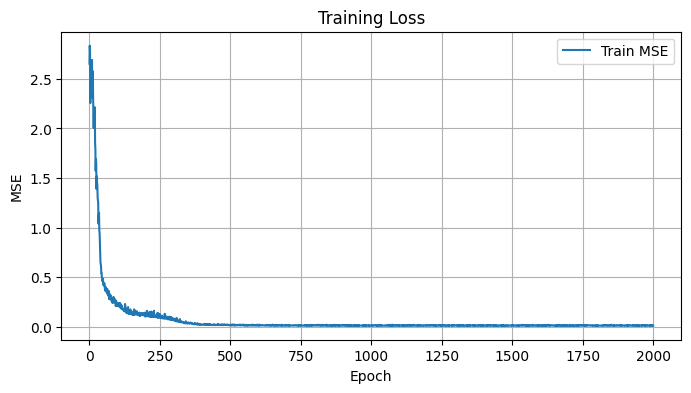

In [14]:
# -----------------------------
# Cell 5 — Training
# -----------------------------
EPOCHS = 2000
train_losses = []

print("[info] Starting autoencoder training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    batch_losses = []

    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    epoch_loss = float(np.mean(batch_losses)) if batch_losses else 0.0
    train_losses.append(epoch_loss)

    if epoch % max(1, EPOCHS // 10) == 0 or epoch == EPOCHS:
        print(f"Epoch {epoch}/{EPOCHS} - Train MSE: {epoch_loss:.6f}")

print("[info] Training finished.")

# Plot training loss
plt.figure(figsize=(8,4))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()


In [15]:
# -----------------------------
# Cell 6 — Anomaly detection using reconstruction error
# -----------------------------
# This cell measures how well the autoencoder reconstructs each sample.
# Large reconstruction error = unusual behavior (potential anomaly).

# Helper function to compute reconstruction errors in batches
# (avoids memory issues on large tensors)
def batch_reconstruction_errors(model, tensor_x, batch_size=256, device=DEVICE):
    model.eval()  # Switch model to evaluation mode
    errors = []

    # No gradients needed during evaluation
    with torch.no_grad():
        n = tensor_x.shape[0]
        for i in range(0, n, batch_size):
            xb = tensor_x[i : i + batch_size].to(device)
            recon = model(xb)

            # Mean squared error per sample
            recon_np = recon.cpu().numpy()
            xb_np = xb.cpu().numpy()
            batch_err = ((recon_np - xb_np) ** 2).mean(axis=1)
            errors.append(batch_err)

    # Combine all batches into one array
    return np.concatenate(errors, axis=0)

# --- Compute reconstruction errors on the training set ---
# These errors define what "normal" behavior looks like
train_errors = batch_reconstruction_errors(model, X_train_t)
train_mean, train_std = train_errors.mean(), train_errors.std()

# Set anomaly threshold at the 95th percentile of training errors
threshold_pct95 = np.percentile(train_errors, 95)
threshold = threshold_pct95

# --- Compute reconstruction errors on the test set ---
test_errors = batch_reconstruction_errors(model, X_test_t)

# Flag samples whose error exceeds the threshold
anomaly_flags = test_errors > threshold
num_anomalies = int(anomaly_flags.sum())
total_test = len(test_errors)

print("\n[info] Anomaly detection summary (test set):")
print(f"  Train mean: {train_mean:.6f}, std: {train_std:.6f}")
print(f"  Threshold (95th pct of train errors): {threshold:.6f}")
print(f"  Test samples: {total_test}, anomalies: {num_anomalies} "
      f"({100.0*num_anomalies/total_test:.2f}%)")

# --- Show the most anomalous test samples ---
top_k = min(10, total_test)
top_idx = np.argsort(test_errors)[-top_k:][::-1]

print("\nTop anomalies (test index | error | anomalous):")
for r, idx in enumerate(top_idx, start=1):
    print(f"{r:2d}. {idx:4d} | {test_errors[idx]:.6f} | {bool(anomaly_flags[idx])}")




[info] Anomaly detection summary (test set):
  Train mean: 0.013925, std: 0.014383
  Threshold (95th pct of train errors): 0.040524
  Test samples: 7, anomalies: 2 (28.57%)

Top anomalies (test index | error | anomalous):
 1.    6 | 0.094624 | True
 2.    5 | 0.061867 | True
 3.    3 | 0.019300 | False
 4.    1 | 0.016018 | False
 5.    4 | 0.008072 | False
 6.    0 | 0.008072 | False
 7.    2 | 0.000647 | False


In [16]:
# -----------------------------
# Cell 7 — Test reconstruction error summary
# -----------------------------
# Print basic statistics to understand the spread of reconstruction errors

print("\n" + "="*60)
print("           Test Reconstruction Error Summary")
print("="*60)

test_mean = test_errors.mean()
test_std = test_errors.std()
test_min = test_errors.min()
test_max = test_errors.max()

print(f"Test Mean MSE: {test_mean:.6f}")
print(f"Test Std:      {test_std:.6f}")
print(f"Test Min:      {test_min:.6f}")
print(f"Test Max:      {test_max:.6f}")
print("="*60)

# Optional: turn this on to visualize the error distribution
plot_hist = False
if plot_hist:
    plt.figure(figsize=(8,4))
    plt.hist(test_errors, bins=25, edgecolor='k')
    plt.title("Histogram of Test Reconstruction Errors")
    plt.xlabel("MSE")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()



           Test Reconstruction Error Summary
Test Mean MSE: 0.029800
Test Std:      0.032348
Test Min:      0.000647
Test Max:      0.094624


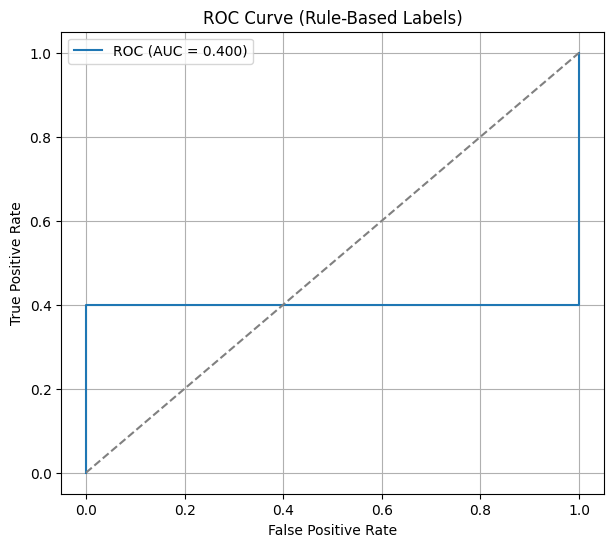

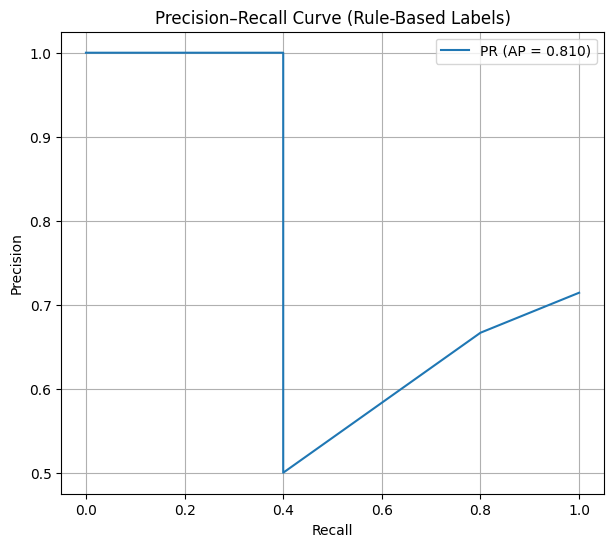


ROC AUC: 0.4
Average Precision (AP): 0.8095238095238095

Confusion matrix at Youden threshold:
[[2 0]
 [4 1]]

Classification report:
              precision    recall  f1-score   support

           0     0.3333    1.0000    0.5000         2
           1     1.0000    0.2000    0.3333         5

    accuracy                         0.4286         7
   macro avg     0.6667    0.6000    0.4167         7
weighted avg     0.8095    0.4286    0.3810         7



In [17]:
# -----------------------------
# Cell 8 — Evaluation against rule-based anomaly labels
# -----------------------------
# This cell compares reconstruction-based anomaly scores against
# simple, human-defined rules to understand how well the model's
# notion of "unusual" aligns with logical inconsistencies in the survey.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)
from sklearn.model_selection import train_test_split
import os
import torch

# --- Configuration ---
CSV_PATH = "survey_responses_cleaned_for_feature_engineering.csv"
TEST_SIZE = 0.2
RANDOM_SEED = 42

# --- Safety helper ---
# If reconstruction errors already exist, reuse them.
# Otherwise, fail loudly so results are not silently incorrect.
def compute_recon_errors_if_missing():
    global test_errors
    if 'test_errors' in globals():
        return
    raise RuntimeError(
        "test_errors not found. Run autoencoder training and anomaly detection first."
    )

# --- Load original survey data as strings ---
# (Used only to apply logical rules, not for model training)
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"{CSV_PATH} not found.")

df_orig = pd.read_csv(CSV_PATH, dtype=str).fillna("")
df = df_orig.copy()
df.columns = [c.strip() for c in df.columns]

# --- Helper to find columns by keyword ---
def find_col_by_keyword(keywords):
    for k in keywords:
        for c in df.columns:
            if k in c.lower():
                return c
    return None

# Attempt to locate relevant survey fields
col_drive = find_col_by_keyword(["do you drive", "i do not drive", "do you have a car", "type of car"])
col_commute = find_col_by_keyword(["commuter type", "commute"])
col_parking_need = find_col_by_keyword(["how long do you need parking", "parking"])
col_num_classes = find_col_by_keyword(["how many classes"])

# --- Rule-based anomaly definitions ---
# Each rule captures a logical inconsistency in responses

# Rule 1: Claims not to drive but still requests parking
r1 = pd.Series(False, index=df.index)
if col_drive and col_parking_need:
    no_drive = df[col_drive].str.lower().str.contains("do not drive|live on campus", na=False)
    needs_parking = ~df[col_parking_need].str.lower().str.contains("^\\s*$|no", regex=True, na=False)
    r1 = no_drive & needs_parking

# Rule 2: Lives on campus but reports a long commute
r2 = pd.Series(False, index=df.index)
if col_drive and col_commute:
    lives_on_campus = df[col_drive].str.lower().str.contains("live on campus|do not drive", na=False)
    long_commute = df[col_commute].str.lower().str.contains("long commute", na=False)
    r2 = lives_on_campus & long_commute

# Rule 3: Implausibly large course load
r3 = pd.Series(False, index=df.index)
if col_num_classes:
    def extract_int(s):
        import re
        m = re.search(r"\d+", str(s))
        return int(m.group()) if m else np.nan
    num_classes = df[col_num_classes].apply(extract_int).astype(float)
    r3 = num_classes > 5

# Rule 4: Requests all-day parking despite short commute or living on campus
r4 = pd.Series(False, index=df.index)
if col_parking_need and col_commute and col_drive:
    all_day = df[col_parking_need].str.lower().str.contains("all day", na=False)
    short_commute = df[col_commute].str.lower().str.contains("short commute|30 minute", na=False)
    r4 = all_day & (short_commute | df[col_drive].str.lower().str.contains("live on campus", na=False))

# Rule 5: Contradictory drive/car-type responses
r5 = pd.Series(False, index=df.index)
if col_drive:
    r5 = (
        df[col_drive].str.lower().str.contains("do not drive", na=False) &
        df[col_drive].str.lower().str.contains("sedan|suv|wagon|coupe", na=False)
    )

# Combine all rules into a single binary label
rule_flags = pd.DataFrame({"r1": r1, "r2": r2, "r3": r3, "r4": r4, "r5": r5})
y_all = rule_flags.any(axis=1).astype(int)

# --- Align labels with the same train/test split used earlier ---
if 'X' not in globals():
    raise RuntimeError("Feature matrix X not found. Run feature engineering first.")

_, _, _, y_test_lab = train_test_split(
    X, y_all.values,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
)

# --- Obtain anomaly scores ---
if 'test_errors' not in globals():
    compute_recon_errors_if_missing()

scores = np.asarray(test_errors).ravel()

if scores.shape[0] != y_test_lab.shape[0]:
    raise ValueError("Mismatch between anomaly scores and test labels.")

# --- ROC and Precision–Recall analysis ---
y_true = y_test_lab.astype(int)

if np.unique(y_true).size < 2:
    print("Only one class present; ROC/PR cannot be computed.")
else:
    fpr, tpr, roc_th = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    prec, rec, pr_th = precision_recall_curve(y_true, scores)
    avg_prec = average_precision_score(y_true, scores)

    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], "--", color="grey")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Rule-Based Labels)")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(7,6))
    plt.plot(rec, prec, label=f"PR (AP = {avg_prec:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curve (Rule-Based Labels)")
    plt.grid(True)
    plt.legend()
    plt.show()

    print("\nROC AUC:", roc_auc)
    print("Average Precision (AP):", avg_prec)

    j_scores = tpr - fpr
    j_idx = np.argmax(j_scores)
    chosen_thr = roc_th[j_idx]

    predicted = (scores > chosen_thr).astype(int)
    print("\nConfusion matrix at Youden threshold:")
    print(confusion_matrix(y_true, predicted))
    print("\nClassification report:")
    print(classification_report(y_true, predicted, digits=4))


In [18]:
# -----------------------------
# Cell 9 — Heuristic open-spot estimate (time-aware)
# -----------------------------
# This cell converts anomaly signals into an estimated number of
# occupied and open parking spots using simple, interpretable rules.

# --- Parking lot assumptions ---
TOTAL_SPOTS = 50              # Total spaces in the lot
WINDOW_SIZE = 20              # Number of recent samples to examine
ASSUMED_ARRIVAL_RATE = 0.6    # Fraction of anomalies assumed to be arrivals

# --- Current time (used only for baseline selection) ---
server_time = datetime.now()
regular_time = server_time.strftime("%I:%M:%S %p").lstrip("0")
pretty_date = server_time.strftime("%B %d, %Y")

# --- Step 1: Choose a baseline based on time of day ---
# Parking demand is much lower overnight than during the day
server_hour = server_time.hour

if 8 <= server_hour < 18:
    dynamic_rate = 0.70
    time_period = "Daytime (Peak)"
elif 18 <= server_hour < 22:
    dynamic_rate = 0.40
    time_period = "Evening (Medium)"
else:
    dynamic_rate = 0.10
    time_period = "Overnight (Low)"

# --- Safety check: make sure anomaly results exist ---
if 'test_errors' not in locals() or 'anomaly_flags' not in locals() or 'threshold' not in locals():
    print("[ERROR] Missing anomaly detection results.")
    raise NameError("Run Cell 6 and 6.5 before this cell.")

# --- Step 2: Measure recent anomaly activity ---
# Look only at the most recent WINDOW_SIZE samples
recent_flags = anomaly_flags[-WINDOW_SIZE:]
recent_total = len(recent_flags)

# Count how many of those were flagged as anomalies
recent_anomalies = int(np.sum(recent_flags))

# --- Step 3: Estimate arrivals vs departures ---
assumed_arrivals = recent_anomalies * ASSUMED_ARRIVAL_RATE
assumed_departures = recent_anomalies * (1.0 - ASSUMED_ARRIVAL_RATE)

# Net change in occupied spots
net_new_occupied = assumed_arrivals - assumed_departures

# --- Step 4: Combine baseline and anomaly adjustment ---
baseline_occupied = int(round(TOTAL_SPOTS * dynamic_rate))
est_occupied_now = baseline_occupied + int(round(net_new_occupied))

# Clamp result so it never exceeds physical limits
est_occupied_now = max(0, min(TOTAL_SPOTS, est_occupied_now))

# Final open-spot estimate
est_open_now = TOTAL_SPOTS - est_occupied_now

# --- Step 5: Display final estimate ---
print("\n" + "="*85)
print(f"Server date: {pretty_date}  Current time: {regular_time} ({time_period})")
print("Estimating Open Spots in SIC Parking Lot (Dynamic Baseline Heuristic)")
print("-"*85)
print(f"Estimated OCCUPIED spots now: {est_occupied_now} / {TOTAL_SPOTS}")
print(f"Estimated OPEN   spots now: {est_open_now} / {TOTAL_SPOTS}")
print("="*85)



Server date: January 25, 2026  Current time: 11:33:58 PM (Overnight (Low))
Estimating Open Spots in SIC Parking Lot (Dynamic Baseline Heuristic)
-------------------------------------------------------------------------------------
Estimated OCCUPIED spots now: 5 / 50
Estimated OPEN   spots now: 45 / 50
